# LSTM Volatility Forecasting
In this notebook we test LSTM-based volatility forecasting against traditional GARCH baselines.  


We import:
- `torch`, `numpy`, `pandas`, `matplotlib` for modeling and analysis  
- `sklearn.metrics` for RMSE/MAE evaluation  
- Project utilities:  
  - `fetch_yf` and `multi_fetch` for data  
  - `LSTMForecaster` and datasets for model training  
  - `metrics` and `rolling_garch_forecast` for baseline evaluation  

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split, DataLoader

from volsense_pkg.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
from volsense_pkg.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_pkg.models.lstm_forecaster import MultiVolDataset, LSTMForecaster, train_lstm, evaluate_lstm
from volsense_pkg.utils.metrics import evaluate_forecasts
from volsense_pkg.utils.metrics import rolling_garch_forecast

# Single-Ticker Dataset Preparation (SPY)
We start with **SPY** (S&P500) as a benchmark:
- Fetch OHLCV data since 1990  
- Compute returns and realized volatility (21-day rolling window)  
- Build a supervised dataset using a sliding window (30-day input → 1-day ahead target)  
- Split into train/validation sets  


In [2]:
# === Data ===
df = fetch_ohlcv("SPY", start="1990-01-01")   # expand training data
df = compute_returns_vol(df, window=21)
series = df["vol_realized"].dropna()

# === Dataset ===
window = 30
dataset = VolDataset(series, window=window, horizon=1)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# LSTM Model: Training on SPY
We define and train a 2-layer LSTM forecaster with dropout:
- Hidden dim = 64, Dropout = 0.2  
- Optimized with Adam for 20 epochs  
After training, we evaluate the model on the validation set using RMSE.  

In [3]:
# === Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)

# === Train ===
model = train_lstm(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)

# === Evaluate ===
preds, actuals = evaluate_lstm(model, val_loader, device=device)
rmse = np.sqrt(mean_squared_error(actuals, preds))
print(f"LSTM RMSE: {rmse:.4f}")

Epoch 1/20 | Train Loss: 0.0058 | Val Loss: 0.0011
Epoch 2/20 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 3/20 | Train Loss: 0.0006 | Val Loss: 0.0005
Epoch 4/20 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 5/20 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 6/20 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 7/20 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 8/20 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 9/20 | Train Loss: 0.0003 | Val Loss: 0.0004
Epoch 10/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 11/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 12/20 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 13/20 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 14/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 15/20 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 16/20 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 17/20 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 18/20 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 19/20 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 20/20 | Train L

# Forecast Evaluation – SPY
We visualize results:
- Compare realized volatility vs LSTM forecast  
- Plot error distribution to check for bias and variance  
This helps verify whether the LSTM tracks volatility dynamics effectively.  

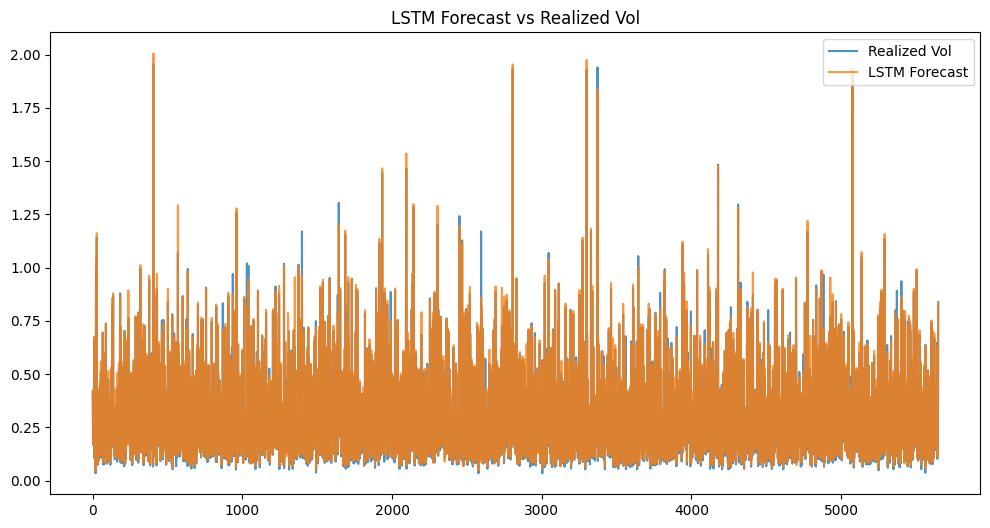

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Realized Vol", alpha=0.8)
plt.plot(preds, label="LSTM Forecast", alpha=0.8)
plt.legend()
plt.title("LSTM Forecast vs Realized Vol")
plt.show()

errors = actuals - preds
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Error Distribution")
plt.show()

# Multi-Ticker Dataset & Training
To improve generalization, we expand to multiple assets (SPY, AAPL, MSFT, TSLA, GOOG).  
Steps:
1. Fetch historical OHLCV data for all tickers  
2. Compute returns + realized vol  
3. Merge into a long-format dataset with a `ticker` column  
4. Train a new LSTM forecaster on this joint dataset  
This allows the model to learn cross-asset volatility patterns.  

In [2]:
# === Fetch Multi-Ticker Data ===
tickers = ["SPY", "AAPL", "MSFT", "TSLA", "GOOG"]
data_dict = fetch_multi_ohlcv(tickers, start="2000-01-01")
multi_df = build_multi_dataset(data_dict)

print(multi_df.head())

# === Dataset ===
window = 30
dataset = MultiVolDataset(multi_df, window=window, horizon=1)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

# === Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)

# === Train ===
model = train_lstm(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price        date    return realized_vol ticker
Ticker                                         
0      2000-02-02 -0.014340     0.841916   AAPL
1      2000-02-03  0.045541     0.806393   AAPL
2      2000-02-04  0.045372     0.819575   AAPL
3      2000-02-07  0.056134     0.770592   AAPL
4      2000-02-08  0.007124     0.758424   AAPL
Epoch 1/20 | Train Loss: 0.0210 | Val Loss: 0.0029
Epoch 2/20 | Train Loss: 0.0028 | Val Loss: 0.0022
Epoch 3/20 | Train Loss: 0.0024 | Val Loss: 0.0017
Epoch 4/20 | Train Loss: 0.0019 | Val Loss: 0.0014
Epoch 5/20 | Train Loss: 0.0016 | Val Loss: 0.0012
Epoch 6/20 | Train Loss: 0.0014 | Val Loss: 0.0010
Epoch 7/20 | Train Loss: 0.0013 | Val Loss: 0.0011
Epoch 8/20 | Train Loss: 0.0012 | Val Loss: 0.0010
Epoch 9/20 | Train Loss: 0.0012 | Val Loss: 0.0008
Epoch 10/20 | Train Loss: 0.0011 | Val Loss: 0.0007
Epoch 11/20 | Train Loss: 0.0011 | Val Loss: 0.0009
Epoch 12/20 | Train Loss: 0.0010 | Val Loss: 0.0008
Epoch 13/20 | Train Loss: 0.0010 | Val Loss: 0.00

# Evaluation: LSTM vs GARCH
We evaluate the multi-ticker LSTM and compare against a GARCH(1,1) baseline:
- **Step 1:** Evaluate LSTM forecasts (RMSE, MAE)  
- **Step 2:** Fit rolling GARCH forecasts on SPY for comparison  
- **Step 3:** Plot realized vs forecast vol for both methods  
- **Step 4:** Compare error distributions (LSTM vs GARCH)  
This highlights the advantage of deep learning models vs traditional econometric baselines.  

LSTM RMSE: 0.0268 | MAE: 0.0148
GARCH RMSE: 0.1306 | MAE: 0.0937


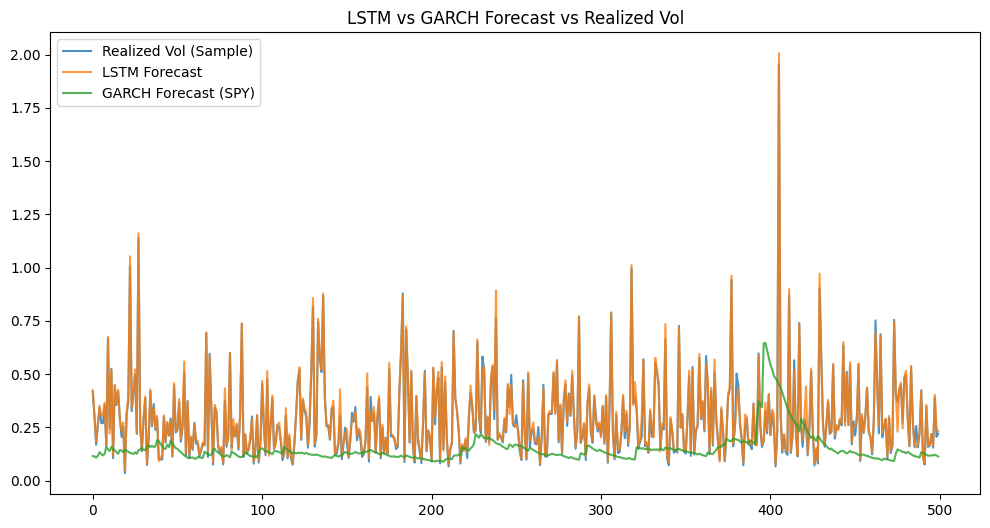

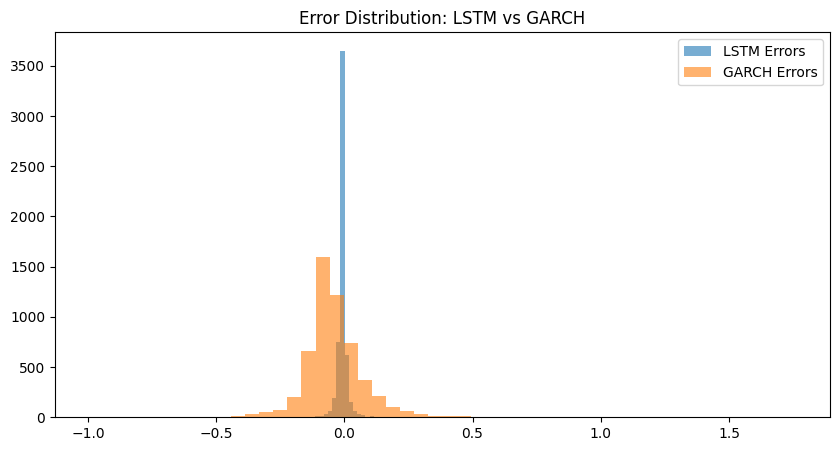

In [4]:
# === 1. Evaluate LSTM ===
preds, actuals = evaluate_lstm(model, val_loader, device=device)
lstm_rmse = np.sqrt(mean_squared_error(actuals, preds))
lstm_mae = np.mean(np.abs(actuals - preds))
print(f"LSTM RMSE: {lstm_rmse:.4f} | MAE: {lstm_mae:.4f}")

# === 2. Evaluate GARCH baseline (on SPY only for speed) ===
spy_df = multi_df[multi_df["ticker"] == "SPY"].copy()
returns = spy_df["return"].dropna()

garch_results = rolling_garch_forecast(returns, window=1000, horizon=1)
garch_metrics = evaluate_forecasts(garch_results)
print(f"GARCH RMSE: {garch_metrics['RMSE']:.4f} | MAE: {garch_metrics['MAE']:.4f}")

# === 3. Plot Comparison ===
plt.figure(figsize=(12,6))
plt.plot(actuals[:500], label="Realized Vol (Sample)", alpha=0.8)
plt.plot(preds[:500], label="LSTM Forecast", alpha=0.8)
plt.plot(garch_results["forecast_vol"].iloc[-500:].values, 
         label="GARCH Forecast (SPY)", alpha=0.8)
plt.legend()
plt.title("LSTM vs GARCH Forecast vs Realized Vol")
plt.show()

# === 4. Error Distribution Comparison ===
lstm_errors = actuals - preds
garch_errors = garch_results["realized_vol"].dropna().values - garch_results["forecast_vol"].dropna().values

plt.figure(figsize=(10,5))
plt.hist(lstm_errors, bins=50, alpha=0.6, label="LSTM Errors")
plt.hist(garch_errors, bins=50, alpha=0.6, label="GARCH Errors")
plt.legend()
plt.title("Error Distribution: LSTM vs GARCH")
plt.show()